In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import tkinter as tk
from tkinter import filedialog
from scipy.interpolate import interp1d
from scipy.signal import find_peaks


# Load the data

# Create a root window and immediately hide it
root = tk.Tk()
root.withdraw()

# This will raise the root window above all others, still is behing notebook browser
root.lift()
root.attributes('-topmost', True)
root.after_idle(root.attributes, '-topmost', False)

# Open a file dialog to select the CSV file
input_file_name = filedialog.askopenfilename(title="Select a CSV file", filetypes=[("CSV files", "*.csv")])

# Check if a file was selected
if not input_file_name:
    print("No file selected. Exiting...")
    
else:
    # Continue with your data processing
    data = pd.read_csv(input_file_name, header=None, skiprows=0, names=['m/z', 'intensity'])
    
    # Extract the directory of the input file and the base name without extension
    input_directory = os.path.dirname(input_file_name)
    base_name = os.path.splitext(os.path.basename(input_file_name))[0]

    # Construct the output file name with the directory and modified base name
    output_file_name = os.path.join(input_directory, base_name + '_output.csv')

print (output_file_name)
print (input_directory)

# Assign column names for convenience
data.columns = ['m/z', 'intensity']

C:/Users/tjun0002/AAA my projects/mass spec folder\testdata_output.csv
C:/Users/tjun0002/AAA my projects/mass spec folder


SMILES, please:   C=CC(=O)OCCCC
Average molecular Weight: 128.171 g/mol
The monoisotopic weight is: 128.083729624 Da


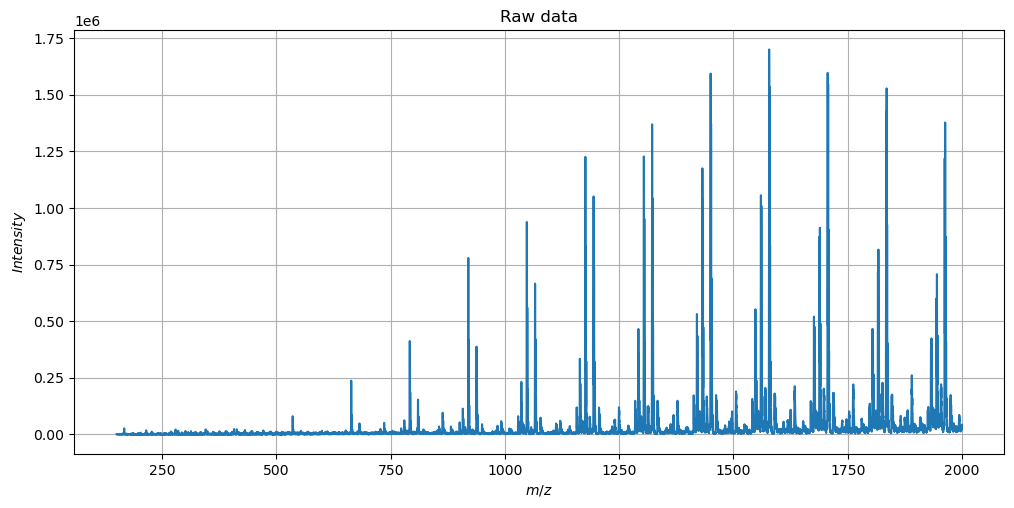

In [5]:
# Function to compute the exact molecular weight from SMILES string

def compute_molecular_weight(smiles_string):
    mol = Chem.MolFromSmiles(smiles_string)
    if mol:    # Check if the molecule is valid
        return Descriptors.MolWt(mol)
    else:
        return "Invalid SMILES string"
    
def compute_monoisotopic_weight(smiles_str):
    mol = Chem.MolFromSmiles(smiles_str)
    if mol:  
        return Descriptors.ExactMolWt(mol)
    else:
        return None

# Test
smiles_input = input("SMILES, please:   ")
weight = compute_molecular_weight(smiles_input)
monoisotopicweight = compute_monoisotopic_weight(smiles_input)
if isinstance(weight, str):
    print(weight)
else:
    print(f"Average molecular Weight: {weight} g/mol")
    print(f"The monoisotopic weight is: {monoisotopicweight} Da")
    
    
# Plot the data
plt.figure(figsize=(12, 5.5))
plt.plot(data['m/z'], data['intensity'], linestyle='-')
plt.title('Raw data')
plt.xlabel('$\mathit{m/z}$')
plt.ylabel('$\mathit{Intensity}$')
plt.grid(True)
plt.show()

Enter minimum m/z value: 750
adjusted lower limit 768.502377744 Da
Enter maximum m/z value: 2000


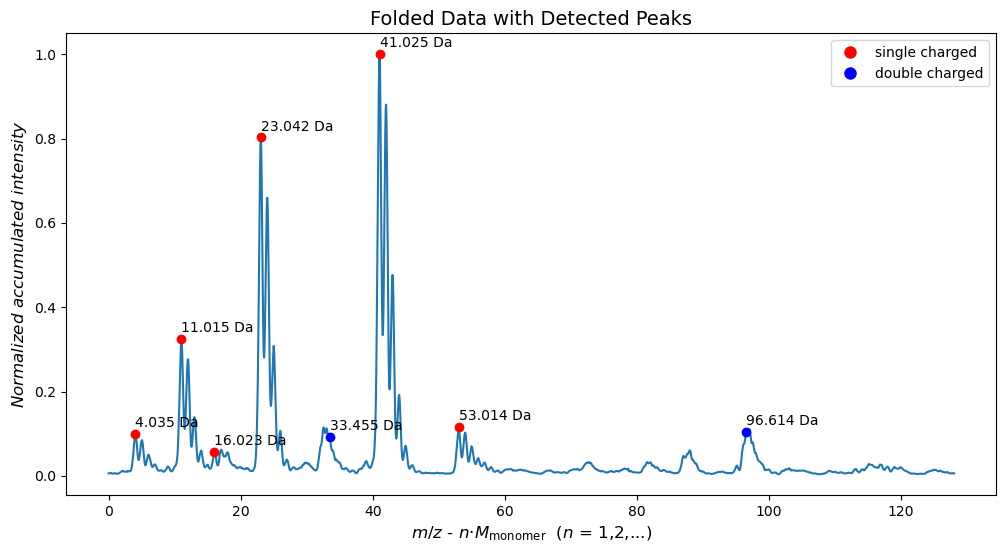

Peaks with z=1:
m/z: 4.035, Relative Intensity: 0.100
m/z: 11.015, Relative Intensity: 0.324
m/z: 16.023, Relative Intensity: 0.058
m/z: 23.042, Relative Intensity: 0.803
m/z: 41.025, Relative Intensity: 1.000
m/z: 53.014, Relative Intensity: 0.115
 
Peaks with z=2:
m/z: 33.455, Relative Intensity: 0.092
m/z: 96.614, Relative Intensity: 0.105


In [6]:
# Get user input for minimum m/z value
min_mz = float(input("Enter minimum m/z value: "))

min_mz = (math.ceil(min_mz/monoisotopicweight)) * monoisotopicweight

print ('adjusted lower limit', min_mz, 'Da')

# Filter data below the minimum m/z
filtered_data = data[data['m/z'] >= min_mz]

# Get user input for maximum m/z value
max_mz = float(input("Enter maximum m/z value: "))

# Filter data above the maximum m/z
filtered_data = filtered_data[filtered_data['m/z'] <= max_mz]

# Subtract the minimum m/z value from all remaining m/z values
normed_data = filtered_data
normed_data['m/z'] = (normed_data['m/z'] - min_mz)/monoisotopicweight

# Interpolation
x = normed_data['m/z'].values
y = normed_data['intensity'].values

f = interp1d(x, y, bounds_error=False, fill_value=0)

max_val = x[-1]  # maximum value in the filtered data

# Create 1000 equally spaced values between 0 and 1
new_x_0_1 = np.linspace(0, 1, 10001)

# Determine step size based on 1000 data points between 0 and 1
step_size = new_x_0_1[1] - new_x_0_1[0]

# Create remaining x values based on the step size
new_x_rest = np.arange(1 + step_size, max_val, step_size)

# Combine the two x arrays
new_x = np.concatenate((new_x_0_1, new_x_rest))

# Get the interpolated y values
new_y = f(new_x)

# Initialize new_y_folded with the first 10,000 values
new_y_folded = new_y[:10000].copy()

# Loop over the data in chunks of 10,000 values
for i in range(10000, len(new_y), 10000):
    end_idx = i + 10000 if i + 10000 < len(new_y) else len(new_y)
    chunk = new_y[i:end_idx]
    new_y_folded[:len(chunk)] += chunk

# Create a new DataFrame for the folded data
folded_data = pd.DataFrame({
    'm/z': new_x[:10000] * monoisotopicweight,  # Only need the first 10,000 m/z values since the data is folded
    'intensity': new_y_folded
})

# Normalize data
folded_data['intensity'] = folded_data['intensity'] / folded_data['intensity'].max()

# Calculate the 5% of the maximum intensity
threshold = 0.05 * folded_data['intensity'].max()

# Detect peaks based on the threshold
peaks, _ = find_peaks(folded_data['intensity'], height=threshold)

# Extract peak m/z and intensity values
peak_mz_values = folded_data['m/z'].iloc[peaks].values
peak_intensity_values = folded_data['intensity'].iloc[peaks].values

# Sort peak m/z and intensity values based on m/z
sorted_indices = np.argsort(peak_mz_values)
peak_mz_values_sorted = peak_mz_values[sorted_indices]
peak_intensity_values_sorted = peak_intensity_values[sorted_indices]

# Calculate the differences between consecutive peak m/z values
differences = np.diff(peak_mz_values_sorted)

# Find the maximum intensity in the whole dataset for normalization
max_global_intensity = folded_data['intensity'].max()

# Define the error margin (e.g., 0.05 for 5%)
error_margin = 0.05

# Initialize variables
start_idx = None
max_intensity = 0
max_intensity_idx = None
spacing_type = None

# Initialize lists to store peak information

peak_info = []

# following code looks for first peak per series

for idx, diff in enumerate(differences):
    if 0.5 - error_margin < diff < 0.5 + error_margin:
        current_spacing = 0.5
    elif 1.0 - error_margin < diff < 1.0 + error_margin:
        current_spacing = 1.0
    else:
        current_spacing = None

    if current_spacing:
        if start_idx is None:  # This means a new group/series has started
            start_idx = idx
            first_peak_intensity = peak_intensity_values_sorted[idx]
            first_peak_mz = peak_mz_values_sorted[idx]
            spacing_type = current_spacing
        # No need to check for max intensity within a group since we are saving the first peak
    else:
        # Spacing suggests the end of a group
        if start_idx is not None:  # Check if we were tracking a group
            peak_info.append((first_peak_mz, first_peak_intensity, spacing_type))
            start_idx = None  # Reset for next group

            
# Lists to store peaks spaced by 1 and their relative intensities
peaks_spacing_1 = []
relative_intensities_spacing_1 = []   

peaks_spacing_05 = []
relative_intensities_spacing_05 = [] 
            
# Plotting the data
plt.figure(figsize=(12,6))
plt.plot(folded_data['m/z'], folded_data['intensity'], label='Data')
for mz, intensity, spacing in peak_info:
    color = 'r' if spacing == 1.0 else 'b'
    plt.plot(mz, intensity, 'o', color=color)
    plt.annotate(f"{mz:.3f} Da", (mz, intensity), textcoords="offset points", xytext=(0,5), ha='left')
    
    # Check if spacing is 1 and store peak m/z and its relative intensity
    if spacing == 1.0:
        peaks_spacing_1.append(mz)
        relative_intensities_spacing_1.append(intensity / max_global_intensity)
        
    # Check if spacing is 05 and store peak m/z and its relative intensity
    if spacing == 0.5:
        peaks_spacing_05.append(mz)
        relative_intensities_spacing_05.append(intensity / max_global_intensity)

plt.xlabel('$\mathit{m/z}$ - $\mathit{n} \xB7 M_{\mathrm{monomer}}$  ($\mathit{n}$ = 1,2,...)', fontsize=12)

plt.ylabel('$\mathit{Normalized}$ $\mathit{accumulated}$ $\mathit{intensity}$', fontsize=12)
red_patch = plt.Line2D([], [], marker='o', color='w', markerfacecolor='r', markersize=10, label='single charged')
blue_patch = plt.Line2D([], [], marker='o', color='w', markerfacecolor='b', markersize=10, label='double charged')
plt.legend(handles=[red_patch, blue_patch])
plt.title('Folded Data with Detected Peaks', fontsize=14)
plt.grid(False)
plt.show()

# Print peaks with 1 spacing and their relative intensities
print("Peaks with z=1:")
for mz, rel_intensity in zip(peaks_spacing_1, relative_intensities_spacing_1):
    print(f"m/z: {mz:.3f}, Relative Intensity: {rel_intensity:.3f}")
    
# Print peaks with 0.5 spacing and their relative intensities
print(" ")
print("Peaks with z=2:")
for mz, rel_intensity in zip(peaks_spacing_05, relative_intensities_spacing_05):
    print(f"m/z: {mz:.3f}, Relative Intensity: {rel_intensity:.3f}")




In [8]:
# Save output data

# Convert peaks to a DataFrame
df_peaks = pd.DataFrame({
    'm/z': peaks_spacing_1 + peaks_spacing_05,
    'Relative Intensity': relative_intensities_spacing_1 + relative_intensities_spacing_05,
    'Spacing': ['z=1'] * len(peaks_spacing_1) + ['z=2'] * len(peaks_spacing_05)
})

# Save peaks data to CSV
with open(output_file_name, 'w') as file:
    df_peaks.to_csv(file, index=False)
    file.write('\n')

# Save folded data to the same CSV
folded_data.to_csv(output_file_name, mode='a', index=False)

In [ ]:
import pandas as pd
import numpy as np
import math
from scipy.interpolate import interp1d
import os
import matplotlib.pyplot as plt

# Example usage:
mz_min = 750
mz_max = 2000
monoisotopicweight = 128.083729624
csv_file_path =  r"YOUR PATH AND FILENAME HERE *.csv"

folded_data = fold_massspec(mz_min, mz_max, monoisotopicweight, csv_file_path)

# Assuming you have already obtained 'folded_data' using the function provided

# Plot 'intensity' against 'm/z'
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(folded_data['m/z'], folded_data['intensity'])
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Mass Spectrometry Data')
plt.grid(True)

# Show the plot
plt.show()

input("Press Enter to exit...")
